<a href="https://colab.research.google.com/github/Aspire-Mayank/EVA/blob/master/Phase2/Session5/EVAPhase2Session_5_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       #transforms.RandomRotation((0,180), resample=True, expand=True, center=None, fill=0)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
print("dataloader_Args",dataloader_args)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
print("Train_loader",train_loader)
# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True
dataloader_Args {'shuffle': True, 'batch_size': 128, 'num_workers': 4, 'pin_memory': True}
Train_loader <torch.utils.data.dataloader.DataLoader object at 0x7fc47dc52cc0>


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
Images shape:  torch.Size([128, 1, 28, 28])
Labels shape:  torch.Size([128])


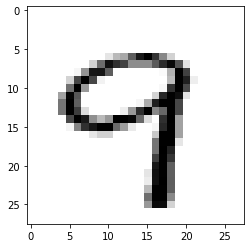

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print("Images shape: ",images.shape)
print("Labels shape: ",labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

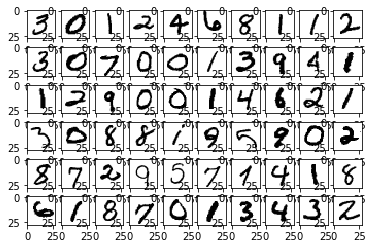

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('on')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.1)            
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)   
        ) # output_size = 24
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.1)   
        )# output_size = 22

        # TRANSITION BLOCK 1
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
            #nn.BatchNorm2d(16)
        )
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 24
        # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)
        ) # output_size = 7
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.1) 
        ) # output_size = 5

        # OUTPUT BLOCK
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
           # nn.BatchNorm2d(10),
           # nn.Dropout(0.1)
        ) # output_size = 5

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(5, 5), padding=0, bias=False),
            #nn.BatchNorm2d(10)
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        #x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [31]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,440
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 22, 22]           1,440
             ReLU-10           [-1, 10, 22, 22]               0
      BatchNorm2d-11           [-1, 10, 22, 22]              20
          Dropout-12           [-1, 10, 22, 22]               0
           Conv2d-13           [-1, 10, 22, 22]             100
             ReLU-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [33]:
model =  Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1, last_epoch=-1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.15458513796329498 Batch_id=468 Accuracy=94.38: 100%|██████████| 469/469 [00:12<00:00, 37.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0789, Accuracy: 9743/10000 (97.43%)

EPOCH: 1


Loss=0.015491168946027756 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:12<00:00, 37.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9855/10000 (98.55%)

EPOCH: 2


Loss=0.01669052429497242 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:11<00:00, 40.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9876/10000 (98.76%)

EPOCH: 3


Loss=0.10422253608703613 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:12<00:00, 37.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9876/10000 (98.76%)

EPOCH: 4


Loss=0.04608181118965149 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:12<00:00, 38.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9887/10000 (98.87%)

EPOCH: 5


Loss=0.02180592715740204 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:12<00:00, 37.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9897/10000 (98.97%)

EPOCH: 6


Loss=0.006494017783552408 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:12<00:00, 38.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9932/10000 (99.32%)

EPOCH: 7


Loss=0.012186032719910145 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:12<00:00, 38.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9933/10000 (99.33%)

EPOCH: 8


Loss=0.13640794157981873 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:11<00:00, 39.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9937/10000 (99.37%)

EPOCH: 9


Loss=0.020724797621369362 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:12<00:00, 38.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.0019555215258151293 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 38.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9936/10000 (99.36%)

EPOCH: 11


Loss=0.03689362481236458 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:11<00:00, 39.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9935/10000 (99.35%)

EPOCH: 12


Loss=0.0038107235450297594 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:12<00:00, 37.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9936/10000 (99.36%)

EPOCH: 13


Loss=0.015750400722026825 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:12<00:00, 38.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9937/10000 (99.37%)

EPOCH: 14


Loss=0.08731422573328018 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:12<00:00, 38.24it/s]



Test set: Average loss: 0.0206, Accuracy: 9937/10000 (99.37%)



Text(0.5, 1.0, 'Test Accuracy')

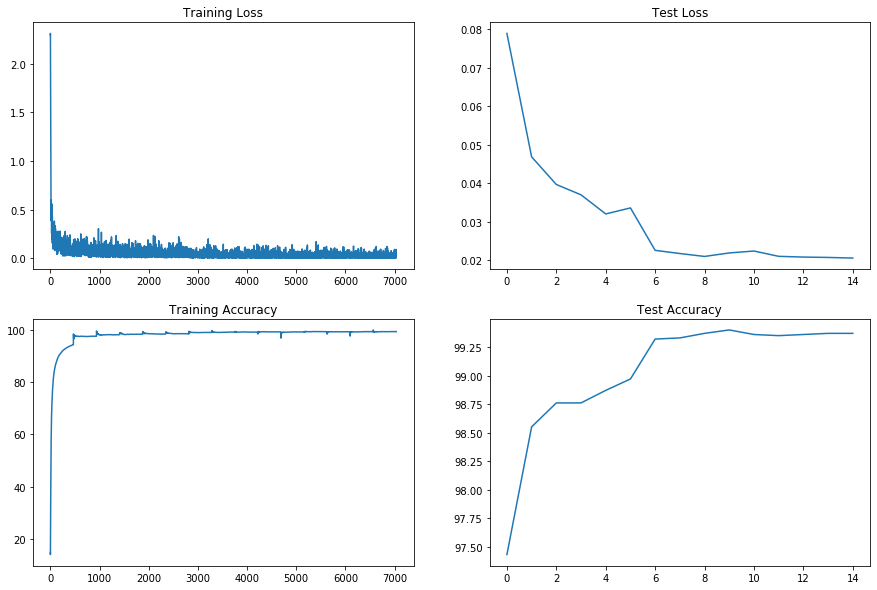

In [35]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
####Assignment: 

Continuing our objective with learning Pytorch, refer to this code: LINK (Links to an external site.)
Change this model in such a way that it:
less than 15k params
uses dropout of 0.1 
uses batchnorm
uses randomrotate transform
uses StepLR with step size = 6 and gamma = 0.1
achieves 99.3% test accuracy
less than 15 epochs. 
Once you're ready, fill in P2S5 Quiz. Also, upload to your PUBLIC GitHub account and be ready with the link. 